In [ ]:
!pip install pandas
!pip install torch torchvision
!pip install cython
!pip install matplotlib
!pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [3]:
import torch.optim as optim
import pandas as pd
import torch
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision.transforms as T

In [4]:

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

class CustomCSVDetectionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_ids = self.df['image_name'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_name'] == image_id]

        image = Image.open(os.path.join(self.images_dir, image_id)).convert("RGB")
        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row['bbox_x']
            ymin = row['bbox_y']
            xmax = xmin + row['bbox_width']
            ymax = ymin + row['bbox_height']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1 if row['label_name'] == 'Marine Animal' else 2)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        # Convert image to tensor if no transformations are applied
        if self.transforms:
            image = self.transforms(image)
        else:
            image = T.ToTensor()(image)

        return image, target

# Define paths
csv_file = '/content/drive/MyDrive/Dataset7.0/train/annotations/train_labels.csv'
images_dir = '/content/drive/MyDrive/Dataset7.0/train/images'

# Create dataset and dataloaders without transformations
dataset = CustomCSVDetectionDataset(csv_file, images_dir, transforms=None)

# DataLoader setup
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
model = get_model(num_classes=3)  # 2 classes (marine animal, trash) + background
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training loop
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 172MB/s]


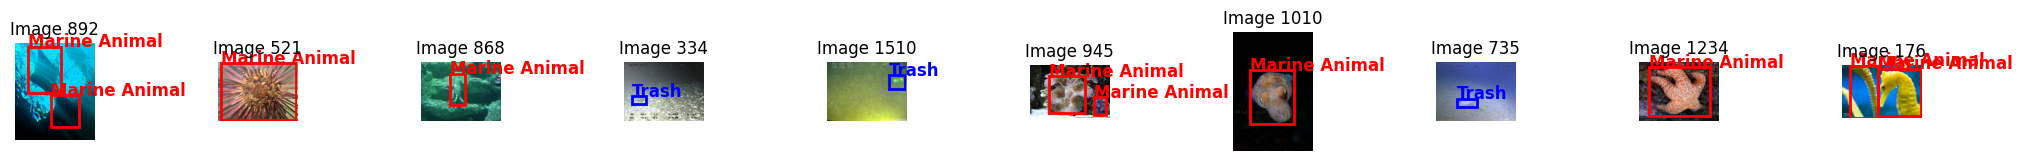

In [5]:


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Define a color map for different labels
LABEL_COLOR_MAP = {
    1: 'r',  # Red for 'Marine Animal'
    2: 'b'   # Blue for 'Trash'
}

def plot_image_with_boxes(image, boxes, labels, ax):
    # Display the image
    ax.imshow(image.permute(1, 2, 0).numpy())

    # Draw the bounding boxes
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        color = LABEL_COLOR_MAP[label.item()]
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add label text above the bounding box
        ax.text(xmin, ymin, 'Marine Animal' if label == 1 else 'Trash', color=color, fontsize=12, weight='bold')

def visualize_random_images(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))

    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        boxes = target['boxes']
        labels = target['labels']

        plot_image_with_boxes(image, boxes, labels, axs[i])
        axs[i].set_title(f"Image {idx+1}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load the dataset without transformations
dataset = CustomCSVDetectionDataset(csv_file, images_dir, transforms=T.ToTensor())
visualize_random_images(dataset)


In [6]:
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} finished")  # Adjust epoch number to start from

    checkpoint_path = f'/content/drive/MyDrive/model_weights_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model weights saved at {checkpoint_path}")

# Saving the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/faster_rcnn_final.pth')
print('Final model weights saved')

# Loading the model
model.load_state_dict(torch.load('/content/drive/MyDrive/faster_rcnn_final.pth'))
model.eval()

Epoch 1 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_1.pth
Epoch 2 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_2.pth
Epoch 3 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_3.pth
Epoch 4 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_4.pth
Epoch 5 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_5.pth
Final model weights saved


<ipython-input-6-2c06e75af2c1>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/faster_rcnn_final.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

***ONLY FOR COPY PASTING PURPOSES DO NOT RUN HERE ONWARDS UNLESS REQUIRED. THIS IS THE CODE TO SAVE THE MODEL INTO A DIFFERENT ACCOUNT AND IMPLEMENT IT FROM THERE ONWARDS***

In [ ]:
model_path = '/content/drive/MyDrive/model_weights_epoch_43.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

Model loaded from /content/drive/MyDrive/model_weights_epoch_43.pth


In [ ]:
# Reinitialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)



In [ ]:
# Continue training from epoch 17 onwards
start_epoch = 43  # THIS WILL KEEP CHANGING BASED ON LAST EPOCH YOU RAN!!!!!!!!!!!!
num_epochs = 15   # WILL REMAIN SAME

for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} finished")  # Adjust epoch number to start from 17

    checkpoint_path = f'/content/drive/MyDrive/model_weights_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model weights saved at {checkpoint_path}")

# Saving the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/faster_rcnn_final.pth')
print('Final model weights saved')

# Loading the model
model.load_state_dict(torch.load('/content/drive/MyDrive/faster_rcnn_final.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 44 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_44.pth
Epoch 45 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_45.pth
Epoch 46 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_46.pth
Epoch 47 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_47.pth
Epoch 48 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_48.pth
Epoch 49 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_49.pth
Epoch 50 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_50.pth
Epoch 51 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_51.pth
Epoch 52 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_52.pth
Epoch 53 finished
Model weights saved at /content/drive/MyDrive/model_weights_epoch_53.pth


***FOR TESTING PURPOSES SOLELY! ONLY TO RUN AFTER ALL EPOCHS COMPLETED***

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.ops import box_iou


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class_colors = {
    1: (255, 165, 0),  # Marine Animal - Orange
    2: (255, 255, 0)   # Trash - Yellow
}

class_names = {
    1: 'Marine Animal',
    2: 'Trash'
}

label_to_int = {
    'Marine Animal': 1,
    'Trash': 2
}

In [ ]:
def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            box = box.astype(np.int32)
            color = class_colors.get(label, (255, 255, 255))
            label_name = class_names.get(label, 'Unknown')

            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(image, f"{label_name}: {score:.2f}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
def visualize_ground_truth(image, boxes, labels):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label in zip(boxes, labels):
        box = box.astype(np.int32)
        color = class_colors.get(label, (255, 255, 255))
        label_name = class_names.get(label, 'Unknown')

        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.putText(image, f"{label_name}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
test_csv_file = '/content/drive/MyDrive/Dataset7.0/test/annotations/test_labels.csv'
test_images_dir = '/content/drive/MyDrive/Dataset7.0/test/images'
test_dataset = CustomCSVDetectionDataset(test_csv_file, test_images_dir)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [ ]:
class CustomCSVDetectionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transforms=None):
        self.annotations = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations['image_name'].unique())

    def __getitem__(self, idx):
        image_name = self.annotations['image_name'].unique()[idx]
        img_path = os.path.join(self.images_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        boxes = self.annotations[self.annotations['image_name'] == image_name][['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].values
        labels = self.annotations[self.annotations['image_name'] == image_name]['label_name']
        labels = labels.map(label_to_int).values

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

In [ ]:
import torch

model.eval()

for images, targets in test_data_loader:
    # Ensure images are tensors and move them to the device
    images = [image.to(device) if isinstance(image, torch.Tensor) else T.ToTensor()(image).to(device) for image in images]

    # Ensure targets are tensors and move them to the device
    targets = [{k: (v.to(device) if isinstance(v, torch.Tensor) else torch.tensor(v).to(device)) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for image, target, output in zip(images, targets, outputs):
        image = image.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy array for visualization
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()

        pred_boxes = output['boxes'].cpu().numpy()
        pred_labels = output['labels'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()

        gt_image = visualize_ground_truth(image, gt_boxes, gt_labels)
        pred_image = visualize_predictions(image, pred_boxes, pred_labels, pred_scores)

        # Plot ground truth and predictions side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(gt_image)
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')

        axes[1].imshow(pred_image)
        axes[1].set_title('Predictions')
        axes[1].axis('off')

        plt.show()


Output hidden; open in https://colab.research.google.com to view.